<a href="https://colab.research.google.com/github/SawsanYusuf/diamond-regression-prediction/blob/main/diamond_regression_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.preprocessing import LabelEncoder

# 1. Prepare Data

In [2]:
df = pd.read_csv("/content/diamonds.csv")
print(df.shape)
df.head()

(53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Dataset Columns:**

-
price : price in US dollars ( $326 - $18,823 )

-
carat : weight of the diamond ( 0.2 - 5.01 )

-
cut : quality of the cut ( Fair , Good , Very Good , Premium , Ideal )

-
color : diamond colour, from J ( worst ) to D ( best )

-
clarity : a measurement of how clear the diamond is ( I1 (worst) ,SI2 ,SI1 ,VS2 ,VS1 ,VVS2 ,VVS1 ,IF (best))

-
x : length in mm ( 0 - 10.74 )

-
y : width in mm ( 0 - 58.9 )

-
z : depth in mm ( 0 - 31.8 )

-
depth : total depth percentage = z / mean( x, y ) = 2 * z / ( x + y ) --> ( 43 - 79 )

-
table : width of top of diamond relative to widest point ( 43 - 95 )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [4]:
# dropping for duplicate data
df = df.drop_duplicates(keep='first')
df.shape

(53940, 11)

We don't have any missing values, and the data types in the correct format.

# 2. Explore (EDA)

## **Carat vs. Price**

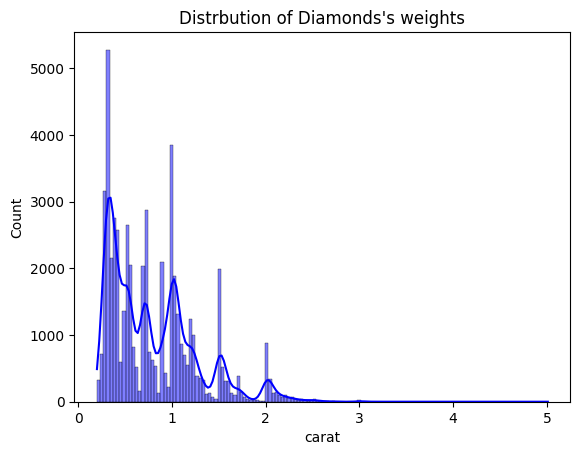

In [5]:
# Plot the distribution
sns.histplot(df.carat, color='b', kde=True).set(title="Distrbution of Diamonds's weights");

Let's look now at the relationship between weight and price.

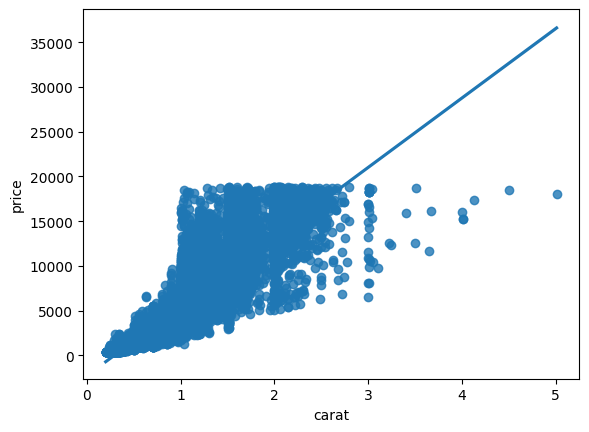

In [6]:
sns.regplot(data=df, x='carat', y='price');

## Color vs. Price

Let's look at the `color` distribution:

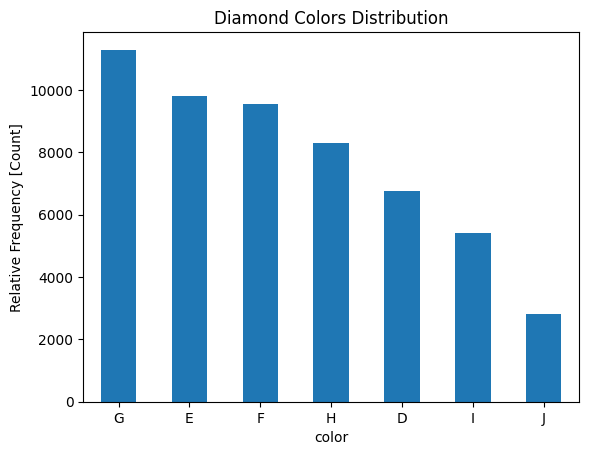

In [7]:
df["color"].value_counts(normalize=False).plot(kind="bar", xlabel="color", ylabel="Relative Frequency [Count]", title="Diamond Colors Distribution")
plt.xticks(rotation=0);

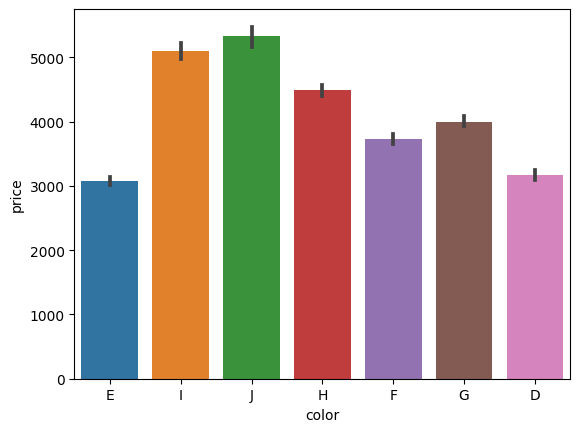

In [8]:
sns.barplot(x="color", y="price", data=df);

## Clarity vs. Price

The distribution of clarity categories through the dataset:

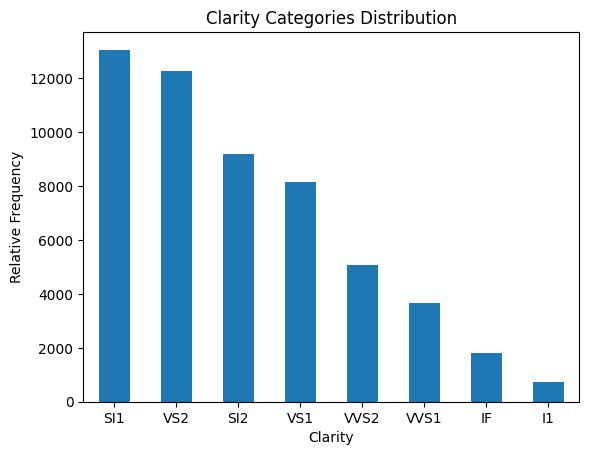

In [9]:
df["clarity"].value_counts(normalize=False).plot(kind="bar", xlabel="Clarity", ylabel="Relative Frequency", title="Clarity Categories Distribution")
plt.xticks(rotation=0);

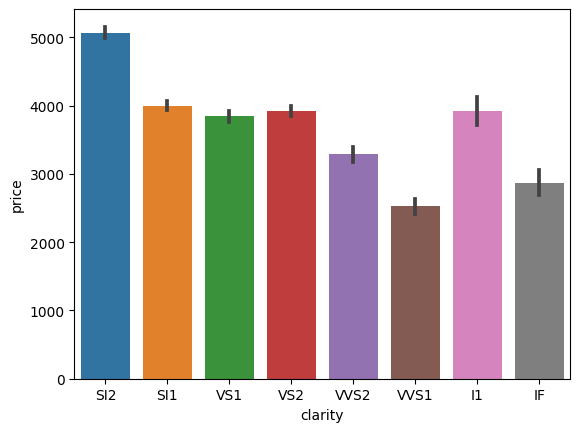

In [10]:
sns.barplot(x="clarity", y="price", data=df);

## Cut vs. Price

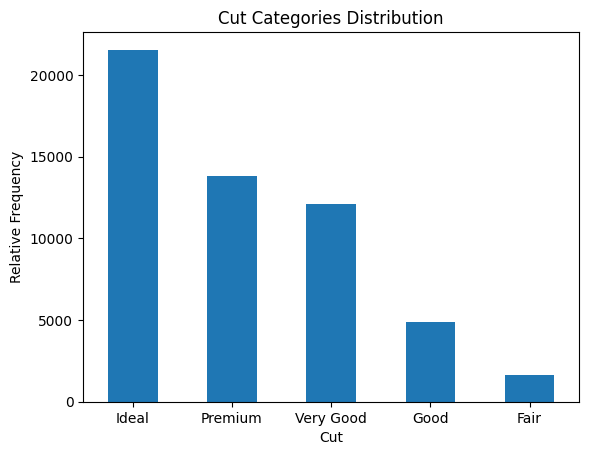

In [11]:
df["cut"].value_counts(normalize=False).plot(kind="bar", xlabel="Cut", ylabel="Relative Frequency", title="Cut Categories Distribution")
plt.xticks(rotation=0);

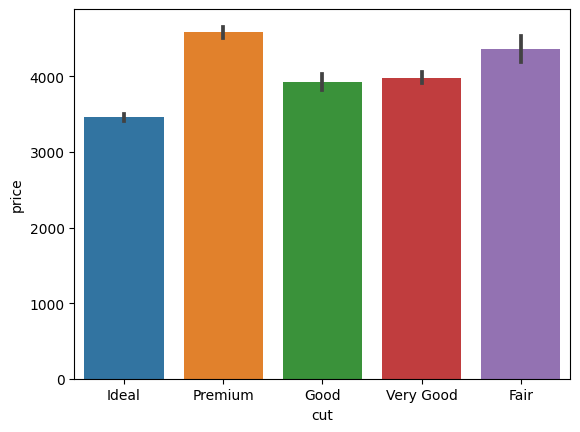

In [12]:
sns.barplot(x="cut", y="price", data=df);

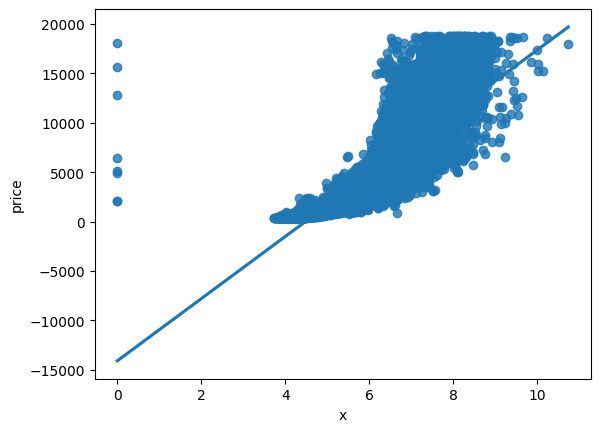

In [13]:
sns.regplot(x="x", y="price", data=df);

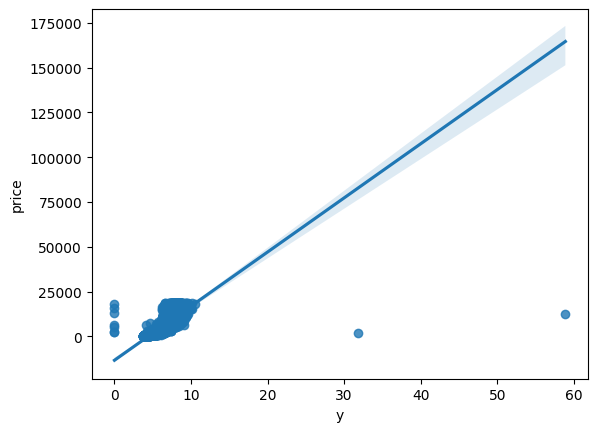

In [14]:
sns.regplot(x="y", y="price", data=df);

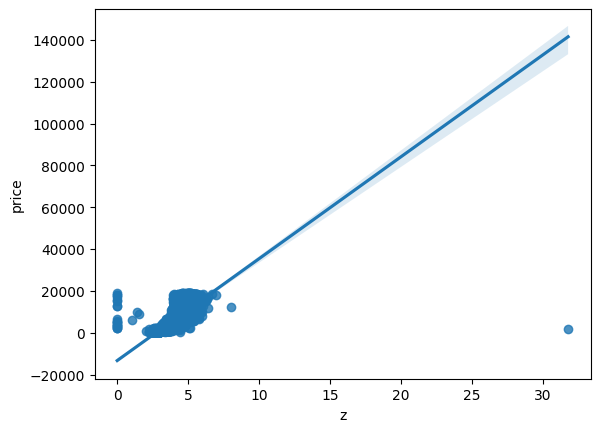

In [15]:
sns.regplot(x="z", y="price", data=df);

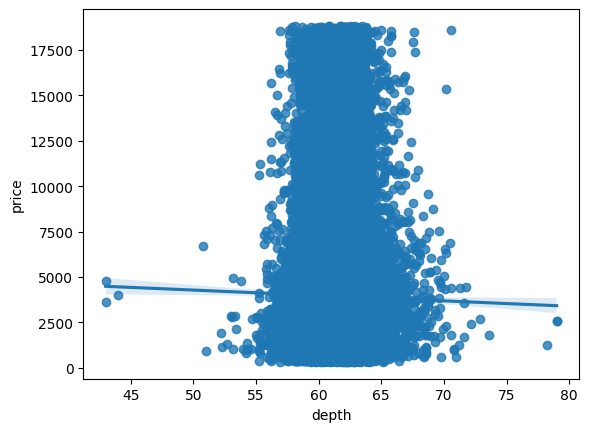

In [16]:
sns.regplot(x="depth", y="price", data=df);

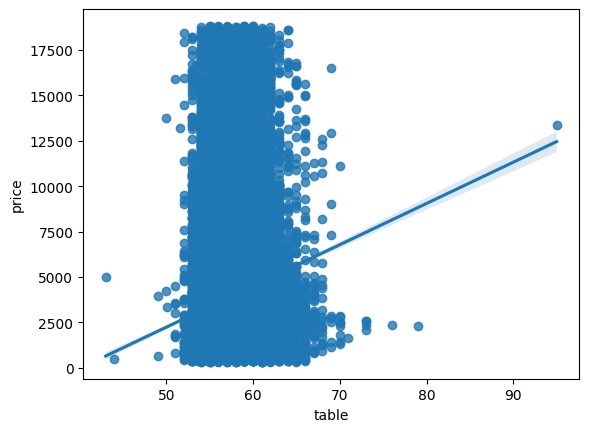

In [17]:
sns.regplot(x="table", y="price", data=df);

<ipython-input-18-4b50e6ec0fe0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


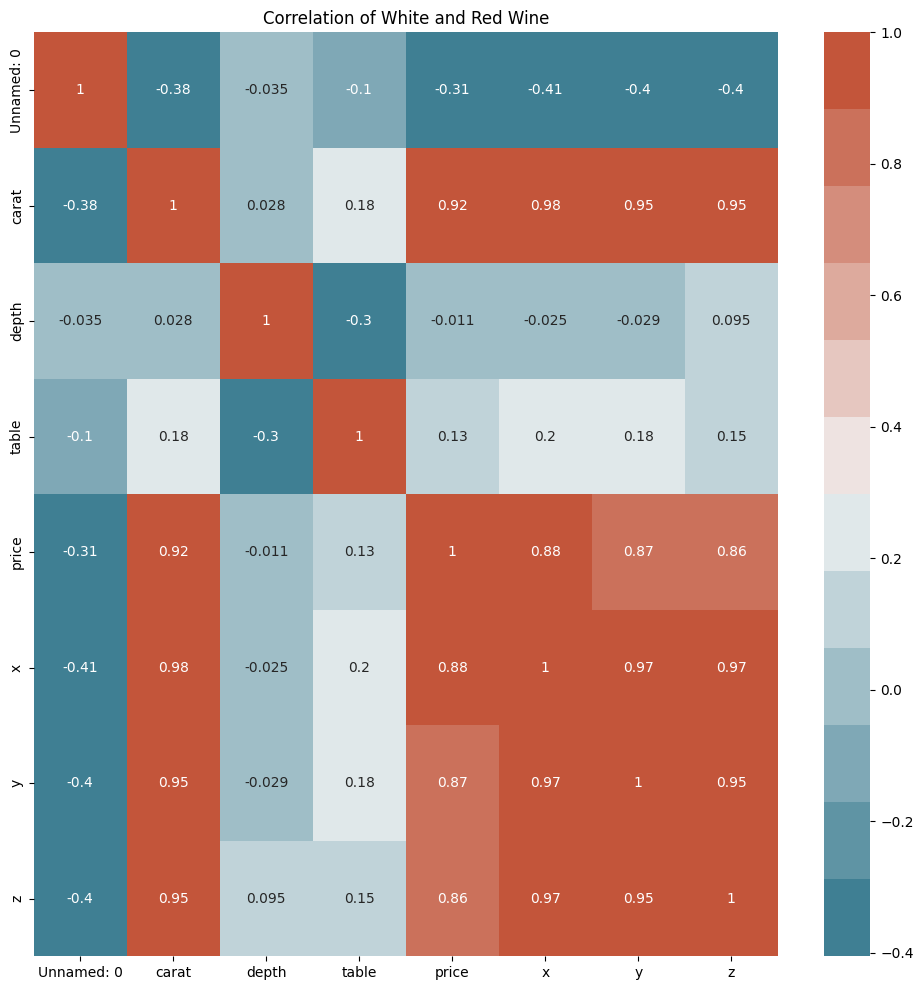

In [18]:
plt.figure(figsize=(12, 12))
df_corr = df.corr()
sns.heatmap(df_corr, cmap=sns.diverging_palette(220, 20, n=12), annot=True)
plt.title("Correlation of White and Red Wine")
plt.show()

In [19]:
lb = LabelEncoder ()

cat_data = ['clarity','cut','color']
for i in cat_data:
    df[i] = lb.fit_transform(df[i])


df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


## Split

In [21]:
target = "price"
X = df.drop(columns = target)
y = df[target]

In [22]:
scalar = StandardScaler()
X = scalar.fit_transform(X)

In [23]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (43152, 9)
y_train shape: (43152,)
X_test shape: (10788, 9)
y_test shape: (10788,)


# Build Model

In [24]:
Model = []
RMSE = []
R_Square = []
CV = []

In [25]:
names = ["Linear Regression", "Ridge Regression", "Lasso Regression",
         "Decision Tree Regressor", "Random Forest Regressor", "Gradient Boosting Regressor",
         "Adaboost Regressor", "BaggingRegressor", "ExtraTreesRegressor","XGBRegressor", "XGBRFRegressor"]
models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(),
          AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(),XGBRegressor(), XGBRFRegressor()]

In [26]:
def evaluate(true, predicted, variable_of_model):
    RMSE.append(np.sqrt(metrics.mean_squared_error(true, predicted)))
    R_Square.append(metrics.r2_score(true, predicted))
    cv_accuracies = cross_val_score(estimator = variable_of_model, X = X_train, y = y_train.ravel(), cv = 5,verbose = 1)
    CV.append(cv_accuracies.mean())

In [ ]:
def fit_and_predict(name, model):
    variable_of_model = model
    variable_of_model.fit(X_train, y_train.ravel())
    pred = variable_of_model.predict(X_test)
    evaluate(y_test, pred, variable_of_model)


for name, model in zip(names, models):
    fit_and_predict(name, model)

In [28]:
evaluation_df = pd.DataFrame({"Model": names,
                                     "RMSE": RMSE,
                                     "R Squared": R_Square,
                                     "Cross Validation": CV})

evaluation_df = evaluation_df.sort_values("R Squared")
evaluation_df

,Model,RMSE,R Squared,Cross Validation
2,Lasso Regression,1351.380562,0.885120,0.884834
0,Linear Regression,1351.263480,0.885140,0.884715
1,Ridge Regression,1351.262006,0.885140,0.884719
6,Adaboost Regressor,1316.330899,0.891002,0.889236
10,XGBRFRegressor,836.841356,0.955947,0.951761
3,Decision Tree Regressor,720.749793,0.967322,0.963983
5,Gradient Boosting Regressor,655.688024,0.972955,0.970641
7,BaggingRegressor,571.528489,0.979452,0.978773
8,ExtraTreesRegressor,541.533516,0.981552,0.980830
4,Random Forest Regressor,540.148896,0.981647,0.980553
